In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib
import copy
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
## Chris' code
def make_meta_map():
    # read in the data
    df_meta = pd.read_excel('../original_data/MNCodebook.xlsx',
                            sheet_name='Variable Values',skiprows=1)
    df_meta = df_meta.fillna(method='ffill')
    # initialize the dictionary
    meta_map = {}
    # populate dictionary
    for idx in range(df_meta.shape[0]):
        name_tmp = df_meta.iloc[idx,0]
        if name_tmp == 'Offense':
            value_tmp = float(df_meta.iloc[idx,1])
        else:
            value_tmp = int(df_meta.iloc[idx,1])
        label_tmp = df_meta.iloc[idx,2]
        if name_tmp not in list(meta_map):
            meta_map[name_tmp] = {}
        meta_map[name_tmp][value_tmp] = label_tmp 
    return meta_map

meta_map = make_meta_map()

In [3]:
data_path = '../original_data/'
file = 'allmn.csv'

all_data = pd.read_csv(data_path+file)

# Throw out unnecessary columns
keep_cols = ['sentyear','race', 'Agecat', 'sex', 'severity', 'history', 'confine', 'time', 'offtype', 'Offense']
all_data = all_data.drop(columns = list(set(all_data.columns)-set(keep_cols)) )
all_data['newtime'] = np.zeros([len(all_data)]) # column for time based on grid

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
## Mask to only keep crimes with severity between 0 and 11 (standard crimes)
all_data = all_data[all_data['severity']<=11]

## Grid data only starts in 2002 so throw out data eariler than that
all_data = all_data[all_data['sentyear']>2001]
all_data = all_data.reset_index(drop=True)
all_data

,sentyear,sex,race,Agecat,offtype,Offense,severity,history,time,confine,newtime
0,2019,1,2,3,7,81.0,4,0,12.03,0.00,0.0
1,2019,1,2,5,1,39.0,4,0,12.03,12.03,0.0
2,2019,1,1,3,1,39.0,4,0,12.03,12.00,0.0
3,2019,1,1,5,1,39.0,4,0,12.03,0.00,0.0
4,2019,1,1,5,1,39.0,4,0,12.03,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
258647,2002,1,1,4,3,71.0,9,6,158.00,156.50,0.0
258648,2002,1,1,3,3,71.0,9,6,161.00,220.00,0.0
258649,2002,1,1,5,3,71.0,9,6,158.00,158.00,0.0
258650,2002,1,1,7,2,40.0,4,0,12.03,0.00,0.0


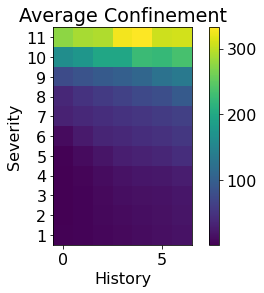

In [5]:
# Calculate average time sentenced for each severity and history level
## And plot
avg_vals = np.zeros([11, 7])
for sever in range(1,12):
    for hist in range(0,7):
        temp = all_data[all_data['severity'] == sever]
        temp = temp[temp['history'] == hist]
        
        avg_vals[sever-1, hist] = np.mean(temp['confine'])
        
avg_vals = np.flipud(avg_vals)

plt.figure()
plt.imshow(avg_vals)
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(list(range(0,11)), labels=ylabels)

plt.title('Average Confinement')
plt.xlabel('History')
plt.ylabel('Severity')
plt.colorbar();

In [6]:
# Load in dictionary with values from sentencing grids 
# and remake 'time' column using that
with open('../generated_data/grid_dictionary.json') as json_file:
    grid_dict = json.load(json_file)
    
for i in all_data.index:
    key_ = str(all_data.loc[i,'sentyear']) + '_' + str(all_data.loc[i,'severity']) + '_' + str(all_data.loc[i,'history'])
    all_data.at[i,'newtime'] = grid_dict[key_]

In [7]:
all_data

,sentyear,sex,race,Agecat,offtype,Offense,severity,history,time,confine,newtime
0,2019,1,2,3,7,81.0,4,0,12.03,0.00,12.0
1,2019,1,2,5,1,39.0,4,0,12.03,12.03,12.0
2,2019,1,1,3,1,39.0,4,0,12.03,12.00,12.0
3,2019,1,1,5,1,39.0,4,0,12.03,0.00,12.0
4,2019,1,1,5,1,39.0,4,0,12.03,0.00,12.0
...,...,...,...,...,...,...,...,...,...,...,...
258647,2002,1,1,4,3,71.0,9,6,158.00,156.50,158.0
258648,2002,1,1,3,3,71.0,9,6,161.00,220.00,158.0
258649,2002,1,1,5,3,71.0,9,6,158.00,158.00,158.0
258650,2002,1,1,7,2,40.0,4,0,12.03,0.00,12.0


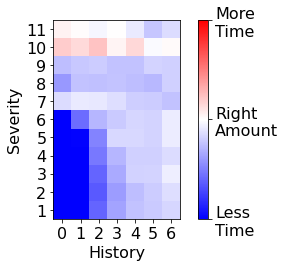

In [18]:
## Calculate average ratio of time sentenced to time prescribed from table
avg_ratio = np.zeros([11, 7])
for sever in range(1,12):
    for hist in range(0,7):
        temp = all_data[all_data['severity'] == sever]
        temp = temp[temp['history'] == hist]
        
        avg_ratio[sever-1, hist] = np.mean((temp['confine']-temp['time'])/temp['time'])
        
avg_ratio = np.flipud(avg_ratio)

plt.figure()
plt.imshow(avg_ratio, cmap='bwr')
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(list(range(0,11)), labels=ylabels)
plt.xticks(list(range(0,7)))


# plt.title('(Confinement-Time)/Time')
plt.xlabel('History')
plt.ylabel('Severity')
cbar = plt.colorbar()
plt.clim([-0.5,0.5])
cbar.set_ticks([-0.5,0,0.5])
cbar.set_ticklabels(['Less\nTime', 'Right\nAmount', 'More\nTime'])
plt.tight_layout()

plt.savefig('grid_heatmap_all.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Severity')

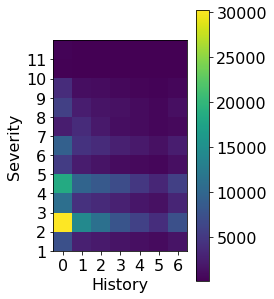

In [9]:
# Make a 2d histogram of how many people are in each bin 

plt.figure(figsize=(3,5))
h = np.histogram2d(all_data['history'], all_data['severity'], bins=[7,11])[0]

plt.imshow(np.flipud(h.T))
ylabels = list(range(1,12))
ylabels.reverse()
plt.yticks(np.array((range(1,12)))-0.5, labels=ylabels)
plt.xticks(list(range(0,7)))

plt.colorbar()

plt.xlabel('History')
plt.ylabel('Severity')

<ipython-input-10-dd57ebbb2a38>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


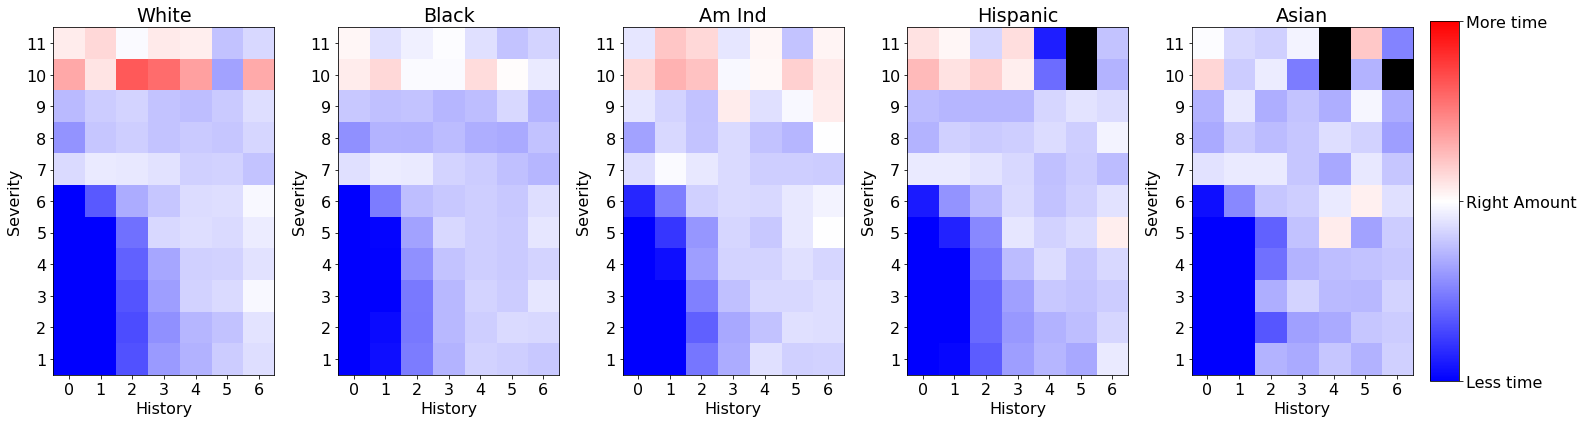

In [10]:
race_dict = meta_map['race']

fig = plt.figure(figsize=(20,10))
for race in range(1,6):
    all_data_race = all_data
    all_data_race = all_data_race[all_data_race['race'] == race]
    avg_ratio = np.zeros([11, 7])
    histcount = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_race[all_data_race['severity'] == sever]
            temp = temp[temp['history'] == hist]
            if len(temp) == 0:
                avg_ratio[sever-1, hist] = np.nan
            else:
                avg_ratio[sever-1, hist] = np.mean((temp['confine']-temp['time'])/temp['time'])
            
    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,race)
    masked_array = np.ma.array(avg_ratio, mask=np.isnan(avg_ratio))
    cmap = copy.copy(matplotlib.cm.bwr)
    cmap.set_bad('black',1.)
    
    im = plt.imshow(masked_array, cmap=cmap)
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)
    plt.xticks(list(range(0,7)))

    plt.title(f'{race_dict[race]}')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([-0.5,0.5])
    
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([-0.5,0,0.5])
cbar.set_ticklabels(['Less time', 'Right Amount', 'More time'])
plt.tight_layout()

plt.savefig('grid_heatmap_race_fromdata.png', dpi=300, bbox_inches='tight')

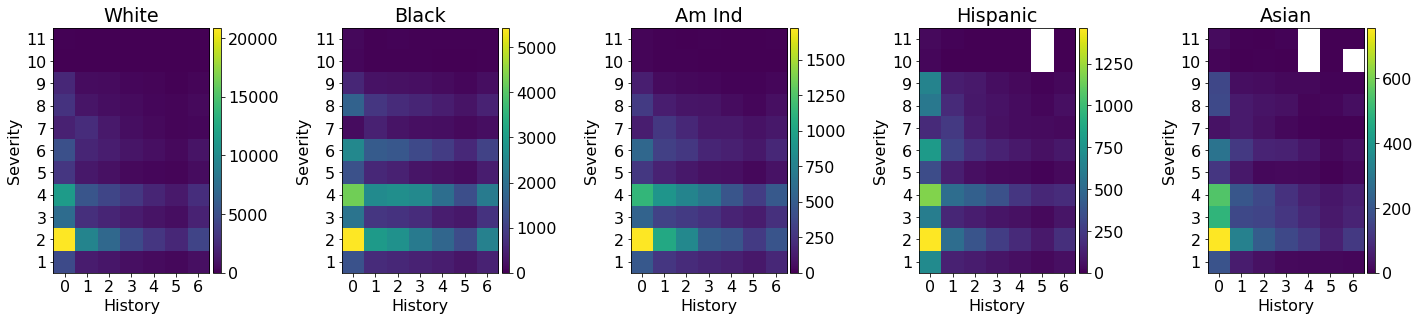

In [11]:
race_dict = meta_map['race']

fig = plt.figure(figsize=(20,10))
for race in range(1,6):
    all_data_race = all_data
    all_data_race = all_data_race[all_data_race['race'] == race]
    histcount = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_race[all_data_race['severity'] == sever]
            temp = temp[temp['history'] == hist]

            histcount[sever-1, hist] = len(temp)
            
    histcount = np.flipud(histcount)
    
    m = np.amax(histcount)
    histcount[histcount == 0.0] = np.nan
    
    subplotnum = int('15'+str(race))
    ax1 = fig.add_subplot(subplotnum)
    im1 = ax1.imshow(histcount)
    im1.set_clim(0, m)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

    ylabels = list(range(1,12))
    ylabels.reverse()
    ax1.set_xticks(list(range(0,7)))
    ax1.set_yticks(list(range(0,11))) 
    ax1.set_yticklabels(ylabels)

    ax1.set_title(f'{race_dict[race]}')
    ax1.set_xlabel('History')
    ax1.set_ylabel('Severity')
    
    
plt.tight_layout()

plt.savefig('grid_heatmap_race_histogram.png', dpi=300, bbox_inches='tight')

<ipython-input-12-99779670a6fe>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


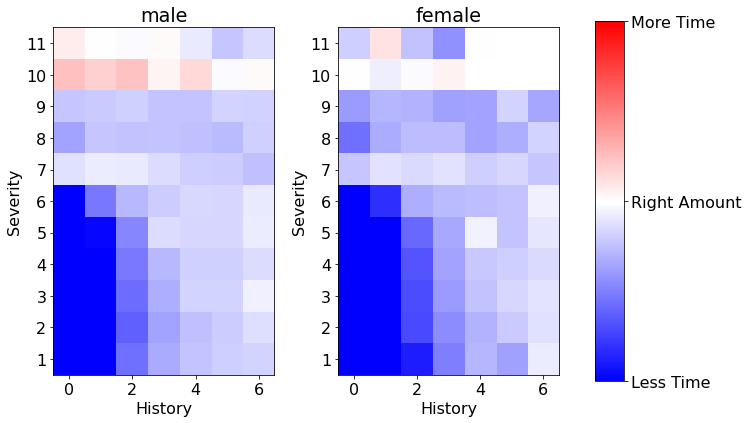

In [12]:
sex_dict = meta_map['sex']

fig = plt.figure(figsize=(20,10))
for sex in range(1,3):
    all_data_sex = all_data[all_data['sex'] == sex]
    avg_ratio = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_sex[all_data_sex['severity'] == sever]
            temp = temp[temp['history'] == hist]

            avg_ratio[sever-1, hist] = np.mean((temp['confine']-temp['time'])/temp['time'])

    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,sex)
    im = plt.imshow(avg_ratio, cmap='bwr')
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)

    plt.title(f'{sex_dict[sex]}')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([-0.5,0.5])
    
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.42, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([-0.5,0,0.5])
cbar.set_ticklabels(['Less Time', 'Right Amount', 'More Time'])
plt.tight_layout()
plt.savefig('grid_heatmap_sex_fromdata.png', dpi=300, bbox_inches='tight')

[[  282.    83.    88.    66.    45.    44.    68.]
 [  187.    59.    59.    33.    27.    20.    34.]
 [ 3161.   979.   901.   624.   441.   278.   569.]
 [ 4695.  2082.  1488.  1215.   872.   570.  1147.]
 [ 2052.  3109.  1840.  1053.   853.   555.   698.]
 [ 7328.  3818.  3345.  2484.  1966.  1261.  2378.]
 [ 4499.  2035.  1411.   899.   707.   479.  1198.]
 [16010.  8818.  7836.  6731.  4694.  3146.  5615.]
 [ 6931.  3163.  2744.  2274.  1564.  1204.  2926.]
 [19369.  9871.  8203.  6069.  4719.  3376.  6541.]
 [ 5821.  2283.  1871.  1452.  1149.   849.  1536.]]
[[3.5000e+01 7.0000e+00 6.0000e+00 2.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00]
 [4.4000e+01 1.0000e+01 2.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [7.1600e+02 1.4300e+02 1.1300e+02 5.1000e+01 3.0000e+01 1.1000e+01
  3.1000e+01]
 [1.1090e+03 3.4400e+02 1.7900e+02 1.3400e+02 7.9000e+01 3.7000e+01
  6.4000e+01]
 [4.2400e+02 5.7800e+02 2.1200e+02 1.0000e+02 5.5000e+01 1.6000e+01
  3.4000e+01]
 [1.9950e+03 6.63

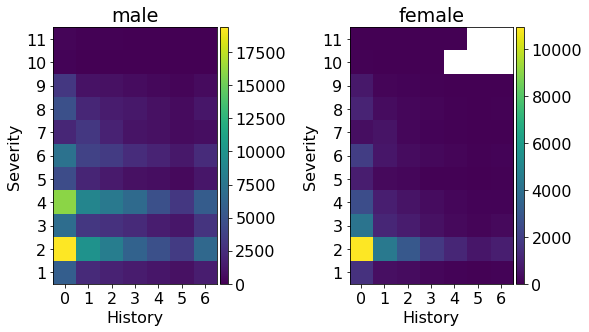

In [13]:
sex_dict = meta_map['sex']

fig = plt.figure(figsize=(20,10))
for sex in range(1,3):
    all_data_sex = all_data[all_data['sex'] == sex]
    histcount = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_sex[all_data_sex['severity'] == sever]
            temp = temp[temp['history'] == hist]

            histcount[sever-1, hist] = len(temp)

    histcount = np.flipud(histcount)
    
    print(histcount)
    
    m = np.amax(histcount)
    histcount[histcount == 0.0] = np.nan
    
    subplotnum = int('15'+str(sex))
    ax1 = fig.add_subplot(subplotnum)
    im1 = ax1.imshow(histcount)
    im1.set_clim(0, m)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    
    ylabels = list(range(1,12))
    ylabels.reverse()
    ax1.set_xticks(list(range(0,7)))
    ax1.set_yticks(list(range(0,11))) 
    ax1.set_yticklabels(ylabels)

    ax1.set_title(f'{sex_dict[sex]}')
    ax1.set_xlabel('History')
    ax1.set_ylabel('Severity')
    
    
plt.tight_layout()

plt.savefig('grid_heatmap_sex_histogram.png', dpi=300, bbox_inches='tight')

## Since the TIME column in the data does not always match what is in the grids, try comparing to the grid values instead

<ipython-input-14-bafa31222fa3>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


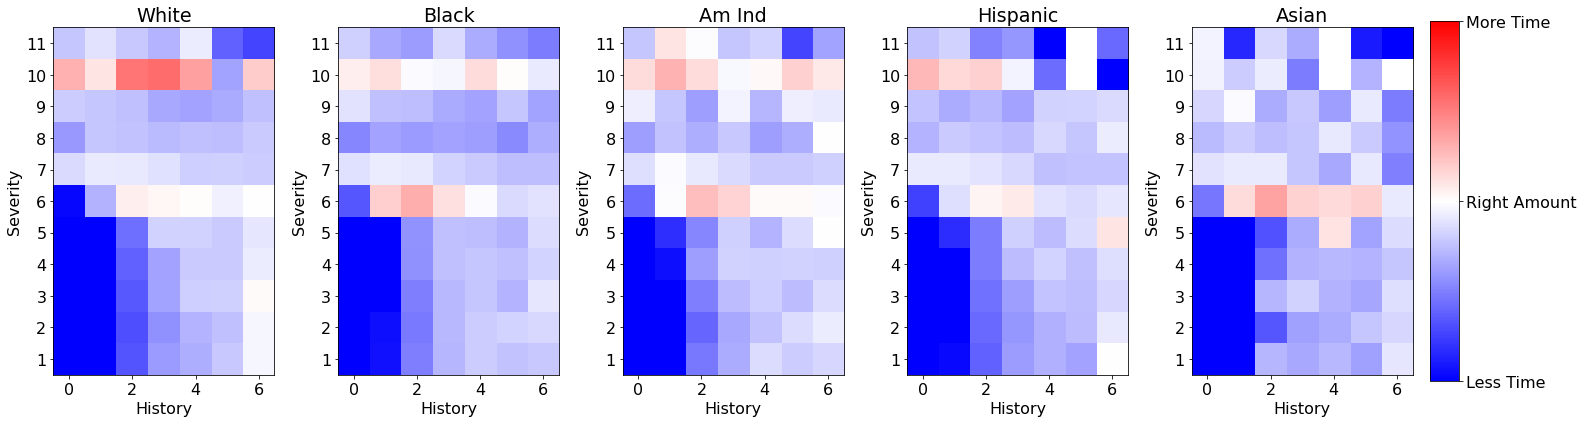

In [14]:
race_dict = meta_map['race']

fig = plt.figure(figsize=(20,10))
for race in range(1,6):
    all_data_race = all_data[all_data['race'] == race]
    avg_ratio = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_race[all_data_race['severity'] == sever]
            temp = temp[temp['history'] == hist]

            avg_ratio[sever-1, hist] = np.mean((temp['confine']-temp['newtime'])/temp['newtime'])

    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,race)
    im = plt.imshow(avg_ratio, cmap='bwr')
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)

    plt.title(f'{race_dict[race]}')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([-0.5,0.5])
    
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([-0.5,0,0.5])
cbar.set_ticklabels(['Less Time', 'Right Amount', 'More Time'])
plt.tight_layout()

plt.savefig('grid_heatmap_race_fromgrid.png', dpi=300, bbox_inches='tight')

<ipython-input-15-12a327768858>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


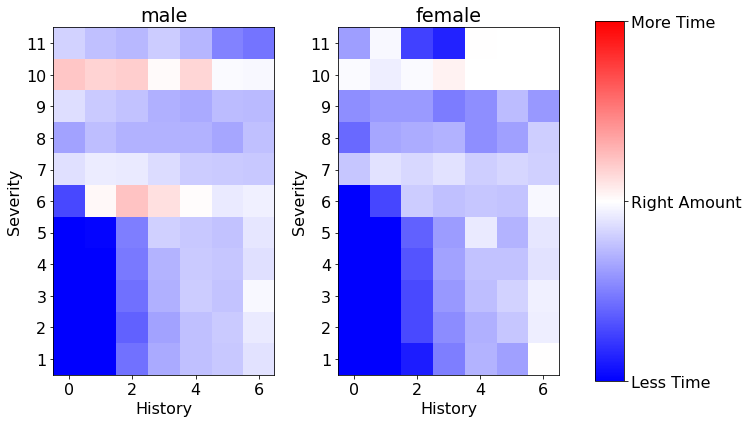

In [15]:
sex_dict = meta_map['sex']

fig = plt.figure(figsize=(20,10))
for sex in range(1,3):
    all_data_sex = all_data[all_data['sex'] == sex]
    avg_ratio = np.zeros([11, 7])
    for sever in range(1,12):
        for hist in range(0,7):
            temp = all_data_sex[all_data_sex['severity'] == sever]
            temp = temp[temp['history'] == hist]

            avg_ratio[sever-1, hist] = np.mean((temp['confine']-temp['newtime'])/temp['newtime'])

    avg_ratio = np.flipud(avg_ratio)
    
    plt.subplot(1,5,sex)
    im = plt.imshow(avg_ratio, cmap='bwr')
    ylabels = list(range(1,12))
    ylabels.reverse()
    plt.yticks(list(range(0,11)), labels=ylabels)

    plt.title(f'{sex_dict[sex]}')
    plt.xlabel('History')
    plt.ylabel('Severity')
    plt.clim([-0.5,0.5])
    
fig.subplots_adjust(right=0.8)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.42, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([-0.5,0,0.5])
cbar.set_ticklabels(['Less Time', 'Right Amount', 'More Time'])

plt.tight_layout()
plt.savefig('grid_heatmap_sex_fromgrid.png', dpi=300, bbox_inches='tight')